Modeling: Results
=================

After fitting strong lens data a phase returns a `result` variable, which we have used sparingly throughout the
examples scripts to plot the maximum log likelihood tracer and fits. However, this `Result` object has a lot more
information than that, and this script will cover everything it contains.

This script uses the result generated in the script `autolens_workspace/notebooks/imaging/modeling/mass_total__source_parametric.py`.
If you have not run the script or its results are not present in the output folder, the model-fit will be performed
again to create the results.

This model-fit fits the strong lens `Imaging` data with:

 - An `EllipticalIsothermal` `MassProfile` for the lens galaxy's mass.
 - An `EllipticalSersic` `LightProfile` for the source galaxy's light.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


The code below, which we have omitted comments from, reperforms all the tasks that create the phase and perform the
model-fit in this script. If anything in this code is not clear to you, you should go over the beginner model-fit
script again.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

phase = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=path.join("imaging", dataset_name),
        name="phase_mass[sie]_source[bulge]",
        n_live_points=50,
    ),
    galaxies=af.Collection(
        lens=af.Model(al.Galaxy, redshift=0.5, mass=al.mp.EllipticalIsothermal),
        source=af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllipticalSersic),
    ),
    settings=al.SettingsPhaseImaging(
        settings_masked_imaging=al.SettingsMaskedImaging(
            grid_class=al.Grid2D, sub_size=2
        )
    ),
)

result = phase.run(dataset=imaging, mask=mask)

INFO:root:phase_mass[sie]_source[bulge] already completed, skipping non-linear search.


Great, so we have the `Result` object we'll cover in this script. As a reminder, we can use the 
`max_log_likelihood_tracer` and `max_log_likelihood_fit` to plot the results of the fit:

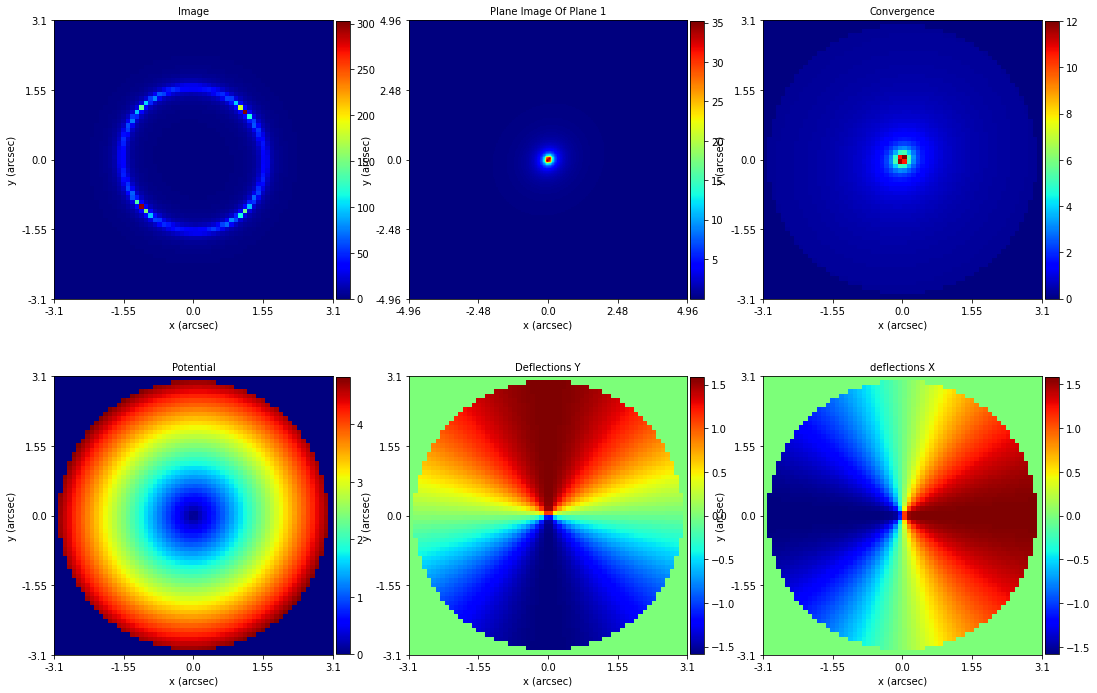

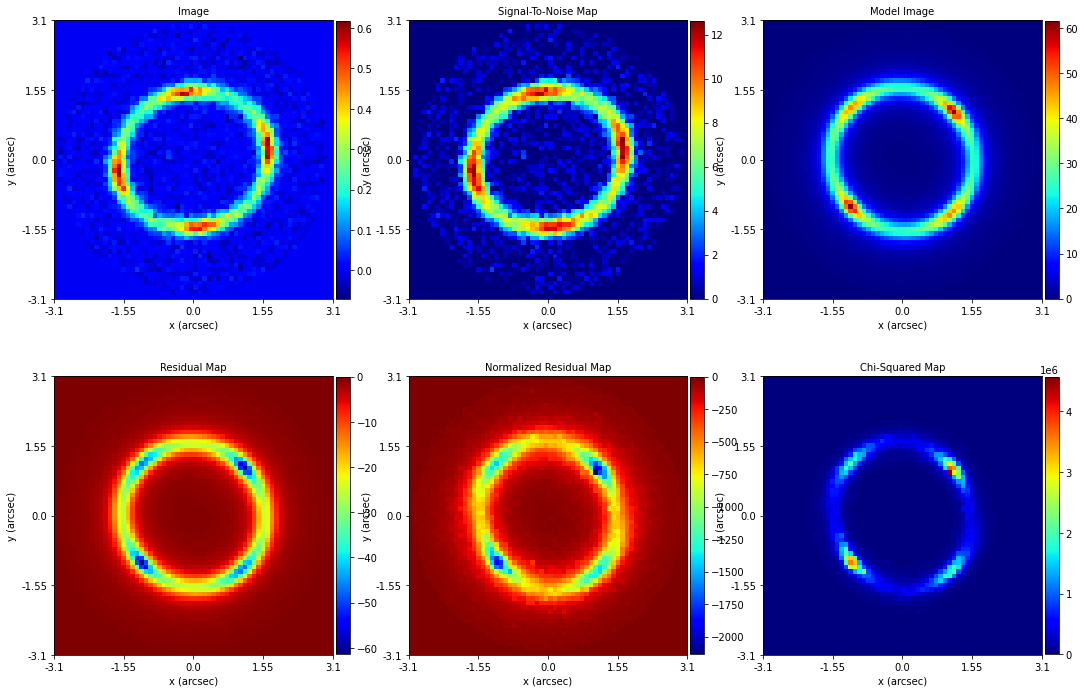

In [3]:
tracer_plotter = aplt.TracerPlotter(
    tracer=result.max_log_likelihood_tracer, grid=mask.masked_grid_sub_1
)
tracer_plotter.subplot_tracer()
fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

The result contains a lot more information about the model-fit. 

For example, its `Samples` object contains the complete set of `NonLinearSearch` samples, for example every set of 
parameters evaluated, their log likelihoods and so on, which are used for computing information about the model-fit 
such as the error on every parameter. Our model-fit used the nested sampling algorithm Dynesty, so the `Samples` object
returned is a `NestSamples` objct.

In [4]:
samples = result.samples

print("Nest Samples: \n")
print(samples)

Nest Samples: 



The `Samples` class contains all the parameter samples, which is a list of lists where:

 - The outer list is the size of the total number of samples.
 - The inner list is the size of the number of free parameters in the fit.

In [5]:
print("All parameters of the very first sample")
print(samples.parameters[0])
print("The fourth parameter of the tenth sample")
print(samples.parameters[9][3])

All parameters of the very first sample
[-0.0014694826946341929, -0.0003657546520058832, 0.05256650652516965, -0.004166551243926616, 1.5994621325541853, -0.0010622074719863583, -0.0012417844559663494, 0.05251089854238374, -0.000156673268111879, 0.999876482446378, 0.7998031959784984, 4.00087036945185]
The fourth parameter of the tenth sample
-0.0002682575479859015


The `Samples` class contains the log likelihood, log prior, log posterior and weights of every sample, where:

   - The log likelihood is the value evaluated from the likelihood function (e.g. -0.5 * chi_squared + the noise 
     normalization).

   - The log prior encodes information on how the priors on the parameters maps the log likelihood value to the log
     posterior value.

   - The log posterior is log_likelihood + log_prior.

   - The weight gives information on how samples should be combined to estimate the posterior. The weight values 
     depend on the sampler used. For example for an MCMC search they will all be 1`s whereas for the nested sampling
     method used in this example they are weighted as a combination of the log likelihood value and prior..

In [6]:
print("log(likelihood), log(prior), log(posterior) and weight of the tenth sample.")
print(samples.log_likelihoods[9])
print(samples.log_priors[9])
print(samples.log_posteriors[9])
print(samples.weights[9])

log(likelihood), log(prior), log(posterior) and weight of the tenth sample.
-1e+99
9.042934388406161
-1e+99
0.0


The `Samples` contain the maximum log likelihood model of the fit (we actually used this when we used the 
max_log_likelihood_tracer and max_log_likelihood_fit properties of the results).

In [7]:
ml_vector = samples.max_log_likelihood_vector
print("Max Log Likelihood Model Parameters: \n")
print(ml_vector, "\n\n")

Max Log Likelihood Model Parameters: 

[0.0008499890893491942, 0.0005497901682569682, 0.05231851219071694, 0.0034306401984030314, 1.5913421295764465, -0.0012020253681814515, -9.808617051775734e-06, 0.052602261522467685, 6.715579283104102e-05, 0.9993669866079403, 0.7992299256361431, 3.999416783709506] 




This provides us with a list of all model parameters. However, this isn't that much use, which values correspond to 
which parameters?

The list of parameter names are available as a property of the `Samples`, as are parameter labels which can be used 
for labeling figures.

In [8]:
print(samples.model.model_component_and_parameter_names)
print(samples.model.parameter_labels)

['galaxies_lens_mass_centre_0', 'galaxies_lens_mass_centre_1', 'galaxies_lens_mass_elliptical_comps_0', 'galaxies_lens_mass_elliptical_comps_1', 'galaxies_lens_mass_einstein_radius', 'galaxies_source_bulge_centre_0', 'galaxies_source_bulge_centre_1', 'galaxies_source_bulge_elliptical_comps_0', 'galaxies_source_bulge_elliptical_comps_1', 'galaxies_source_bulge_intensity', 'galaxies_source_bulge_effective_radius', 'galaxies_source_bulge_sersic_index']
['y', 'x', '\\xi', '\\xi', '\\theta', 'y', 'x', '\\xi', '\\xi', 'I', 'R', 'n']


These lists will be used later for visualization, however it can be more useful to create the model instance of every 
fit.

In [9]:
ml_instance = samples.max_log_likelihood_instance
print("Maximum Log Likelihood Model Instance: \n")
print(ml_instance, "\n")

Maximum Log Likelihood Model Instance: 




A model instance contains all the model components of our fit, most importantly the list of galaxies we specified in 
the pipeline.

In [10]:
print(ml_instance.galaxies)

print(ml_instance.galaxies.lens)
print(ml_instance.galaxies.source)

In [11]:
print(ml_instance.galaxies.lens.mass)

EllipticalIsothermal
centre: (0.0008499890893491942, 0.0005497901682569682)
elliptical_comps: (0.05231851219071694, 0.0034306401984030314)
axis_ratio: 0.9003623507883424
phi: 43.12418012526533
einstein_radius: 1.5913421295764465
slope: 2.0
core_radius: 0.0
id: 27
_assertions: []
cls: <class 'autogalaxy.profiles.mass_profiles.total_mass_profiles.EllipticalIsothermal'>


We can use this list of galaxies to create the maximum log likelihood `Tracer`, which, funnily enough, 
is the property of the result we've used up to now!

(If we had the `MaskedImaging` available we could easily use this to create the maximum log likelihood `FitImaging`.

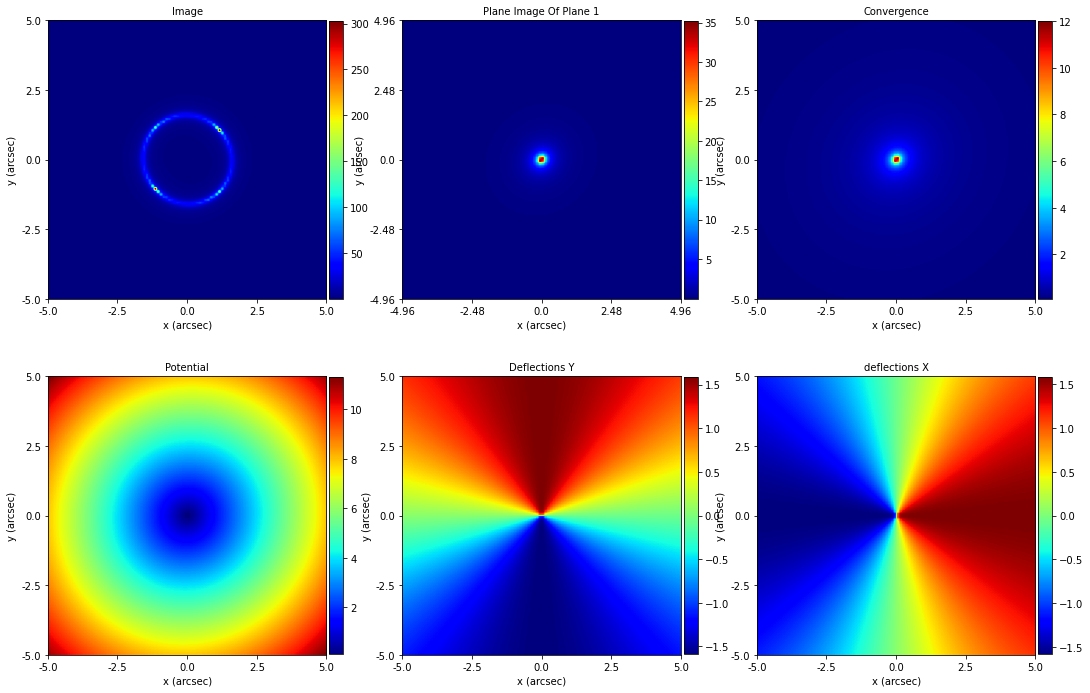

In [12]:
ml_tracer = al.Tracer.from_galaxies(galaxies=ml_instance.galaxies)

tracer_plotter = aplt.TracerPlotter(tracer=ml_tracer, grid=mask.unmasked_grid_sub_1)
tracer_plotter.subplot_tracer()

We can also access the `median pdf` model, which is the model computed by marginalizing over the samples of every 
parameter in 1D and taking the median of this PDF.

In [13]:
mp_vector = samples.median_pdf_vector
mp_instance = samples.median_pdf_instance

print("Median PDF Model Parameter Lists: \n")
print(mp_vector, "\n")
print("Most probable Model Instances: \n")
print(mp_instance, "\n")
print(mp_instance.galaxies.lens.mass)
print()

Median PDF Model Parameter Lists: 

[0.0008499890893491942, 0.0005497901682569682, 0.05231851219071694, 0.0034306401984030314, 1.5913421295764465, -0.0012020253681814515, -9.808617051775734e-06, 0.052602261522467685, 6.715579283104102e-05, 0.9993669866079403, 0.7992299256361431, 3.999416783709506] 

Most probable Model Instances: 


EllipticalIsothermal
centre: (0.0008499890893491942, 0.0005497901682569682)
elliptical_comps: (0.05231851219071694, 0.0034306401984030314)
axis_ratio: 0.9003623507883424
phi: 43.12418012526533
einstein_radius: 1.5913421295764465
slope: 2.0
core_radius: 0.0
id: 27
_assertions: []
cls: <class 'autogalaxy.profiles.mass_profiles.total_mass_profiles.EllipticalIsothermal'>



We can compute the model parameters at a given sigma value (e.g. at 3.0 sigma limits).

These parameter values do not account for covariance between the model. For example if two parameters are degenerate 
this will find their values from the degeneracy in the `same direction` (e.g. both will be positive). we'll cover
how to handle covariance elsewhere.

Here, I use "uv3" to signify this is an upper value at 3 sigma confidence,, and "lv3" for the lower value.

In [14]:
uv3_vector = samples.vector_at_upper_sigma(sigma=3.0)
uv3_instance = samples.instance_at_upper_sigma(sigma=3.0)
lv3_vector = samples.vector_at_lower_sigma(sigma=3.0)
lv3_instance = samples.instance_at_lower_sigma(sigma=3.0)

print("Errors Lists: \n")
print(uv3_vector, "\n")
print(lv3_vector, "\n")
print("Errors Instances: \n")
print(uv3_instance, "\n")
print(lv3_instance, "\n")

Errors Lists: 

[0.001588687810374787, 0.0019309847025757976, 0.05299017837439776, 0.004385353552968181, 1.6090859138788431, 0.0027865744266823336, 0.0023542235988739707, 0.052770053285143684, 0.00019465425552337446, 1.0000869112028292, 0.8009558207265887, 4.0009950766261] 

[-0.0022242140294931683, -0.00218110610528198, 0.05201721023598535, -0.004743589191966502, 1.5900482262726354, -0.0016214035283513794, -0.002852418027349021, 0.05238814578634019, -0.00018250289570089398, 0.9990618652978124, 0.7990532154295314, 3.999045905044948] 

Errors Instances: 





We can compute the upper and lower errors on each parameter at a given sigma limit.

Here, "ue3" signifies the upper error at 3 sigma. 

( Need to fix bug, sigh).

In [15]:
# ue3_vector = samples.error_vector_at_upper_sigma(sigma=3.0)
# ue3_instance = samples.error_instance_at_upper_sigma(sigma=3.0)
# le3_vector = samples.error_vector_at_lower_sigma(sigma=3.0)
# le3_instance = samples.error_instance_at_lower_sigma(sigma=3.0)
#
# print("Errors Lists: \n")
# print(ue3_vector, "\n")
# print(le3_vector, "\n")
# print("Errors Instances: \n")
# print(ue3_instance, "\n")
# print(le3_instance, "\n")

The maximum log likelihood of each model fit and its Bayesian log evidence (estimated via the nested sampling 
algorithm) are also available.

In [16]:
print("Maximum Log Likelihood and Log Evidence: \n")
print(max(samples.log_likelihoods))
print(samples.log_evidence)

Maximum Log Likelihood and Log Evidence: 

-180112458.12509567
-180112462.78967375


The Probability Density Functions (PDF's) of the results can be plotted using the library:

 corner.py: https://corner.readthedocs.io/en/latest/

(In built visualization for PDF's and non-linear searches is a future feature of PyAutoFit, but for now you`ll have to 
use the libraries yourself!).

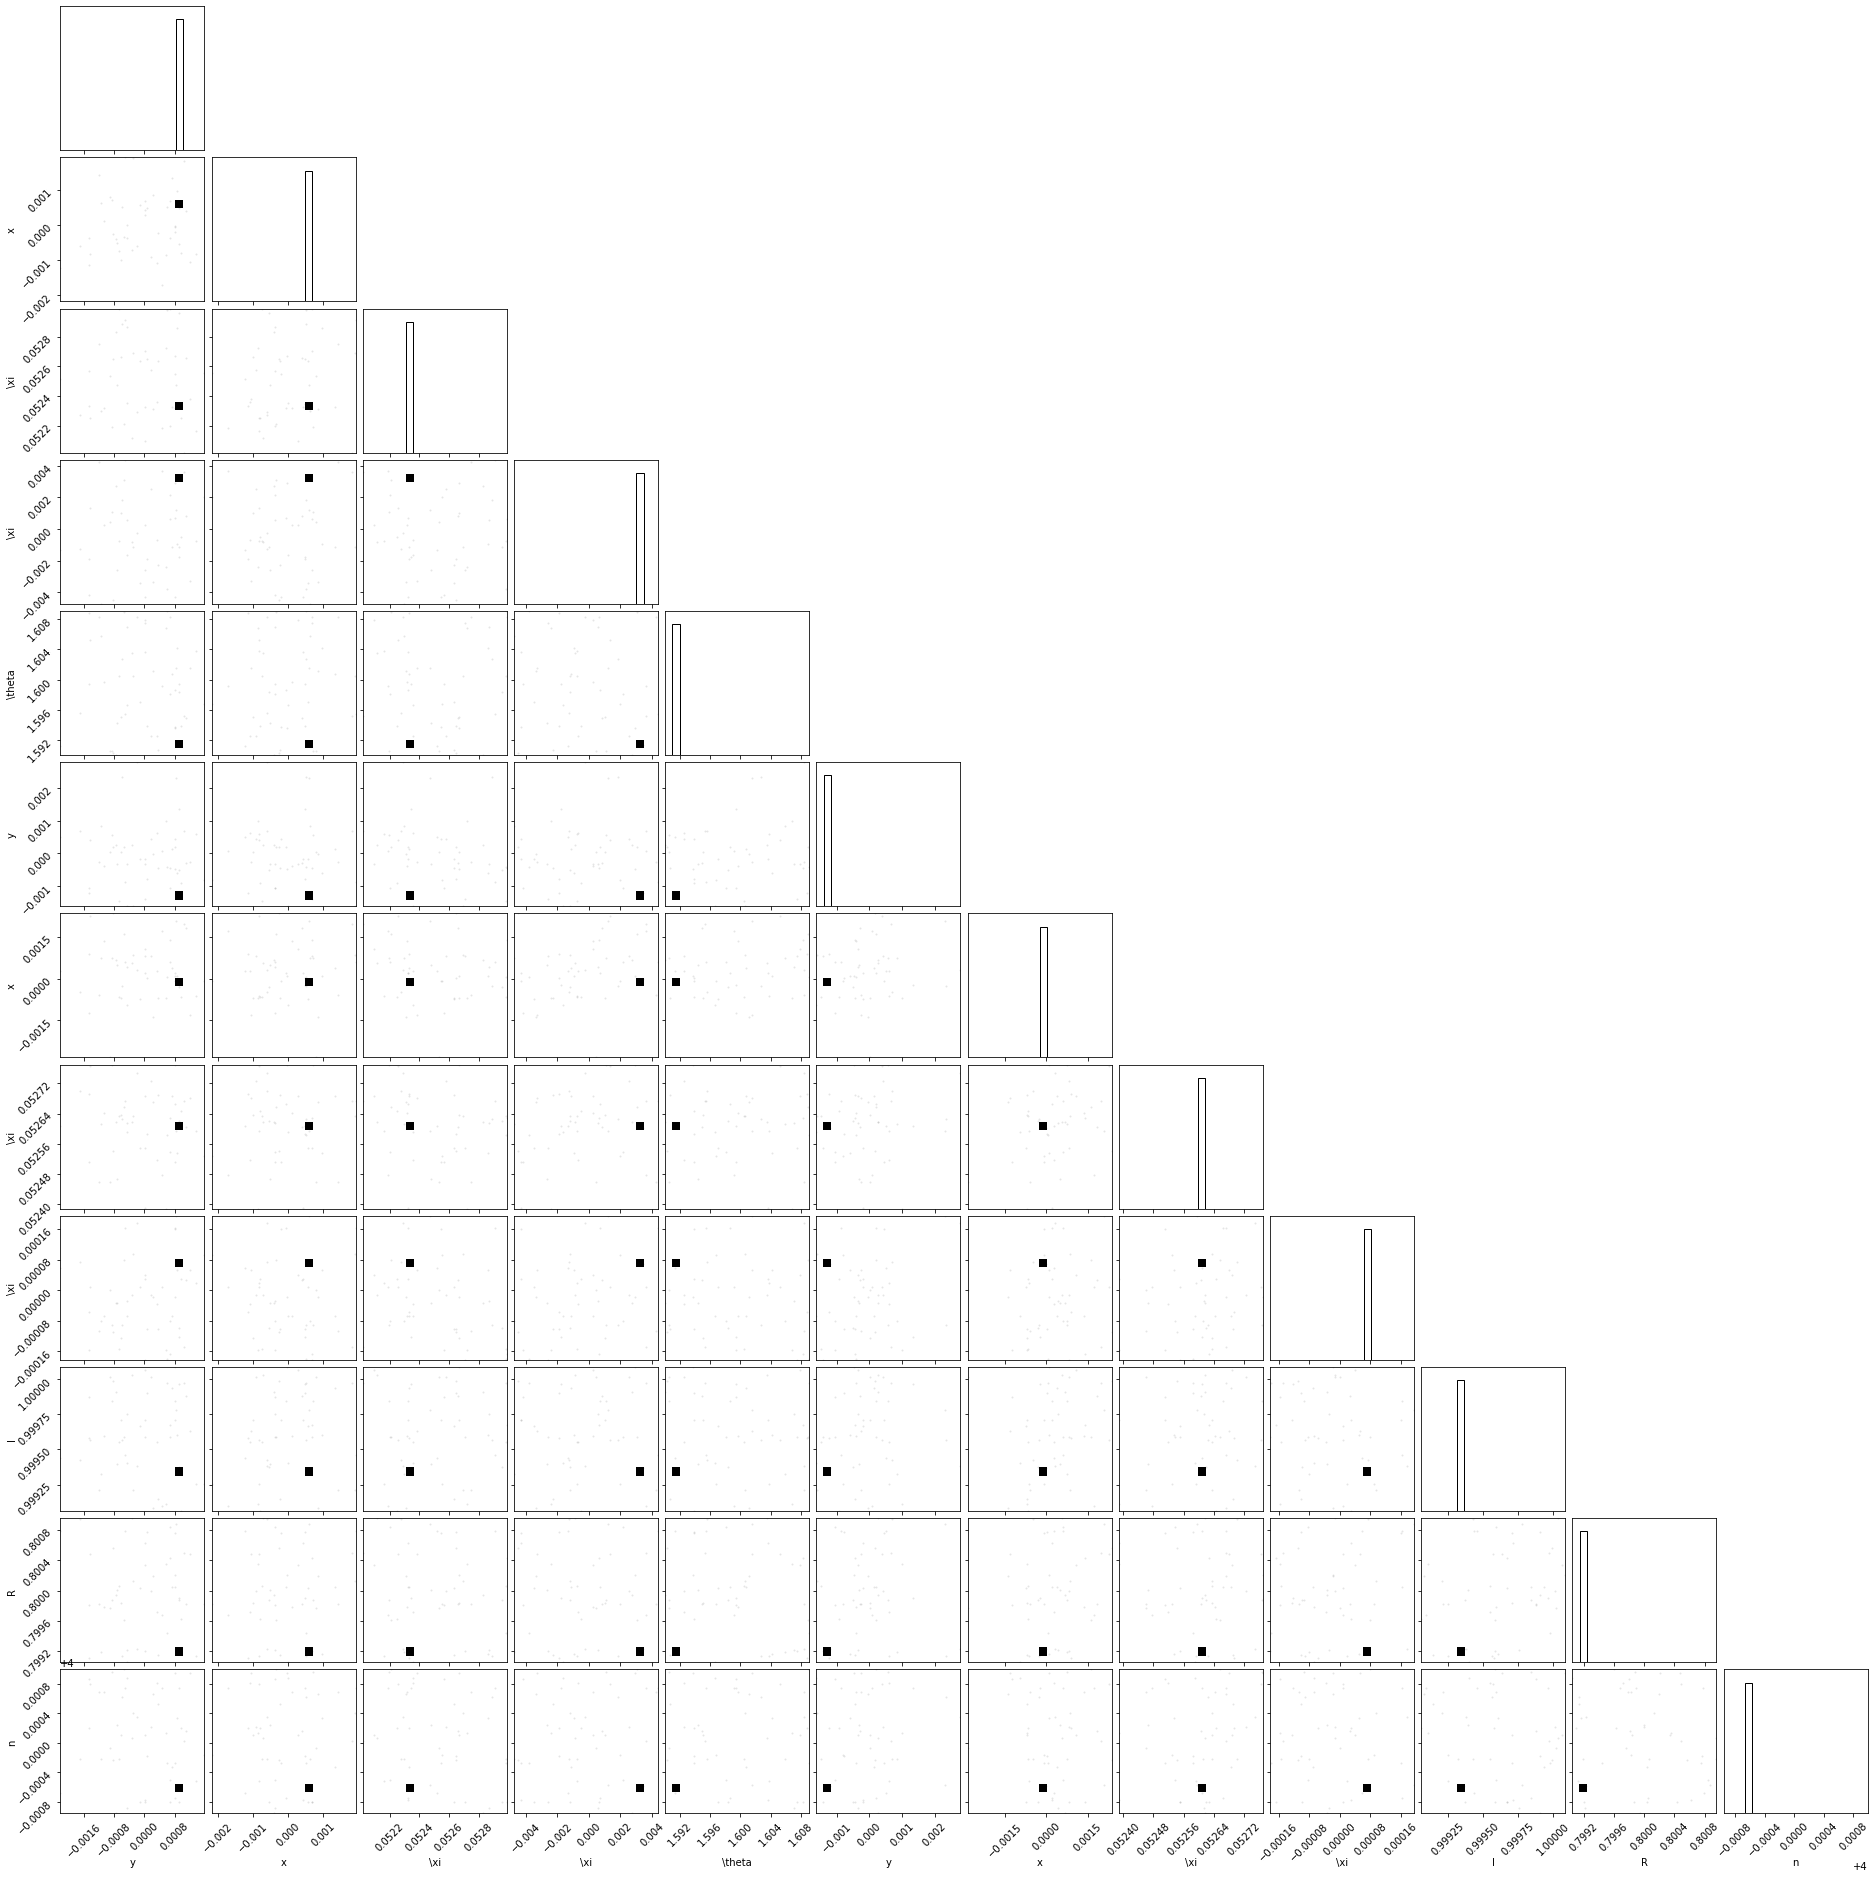

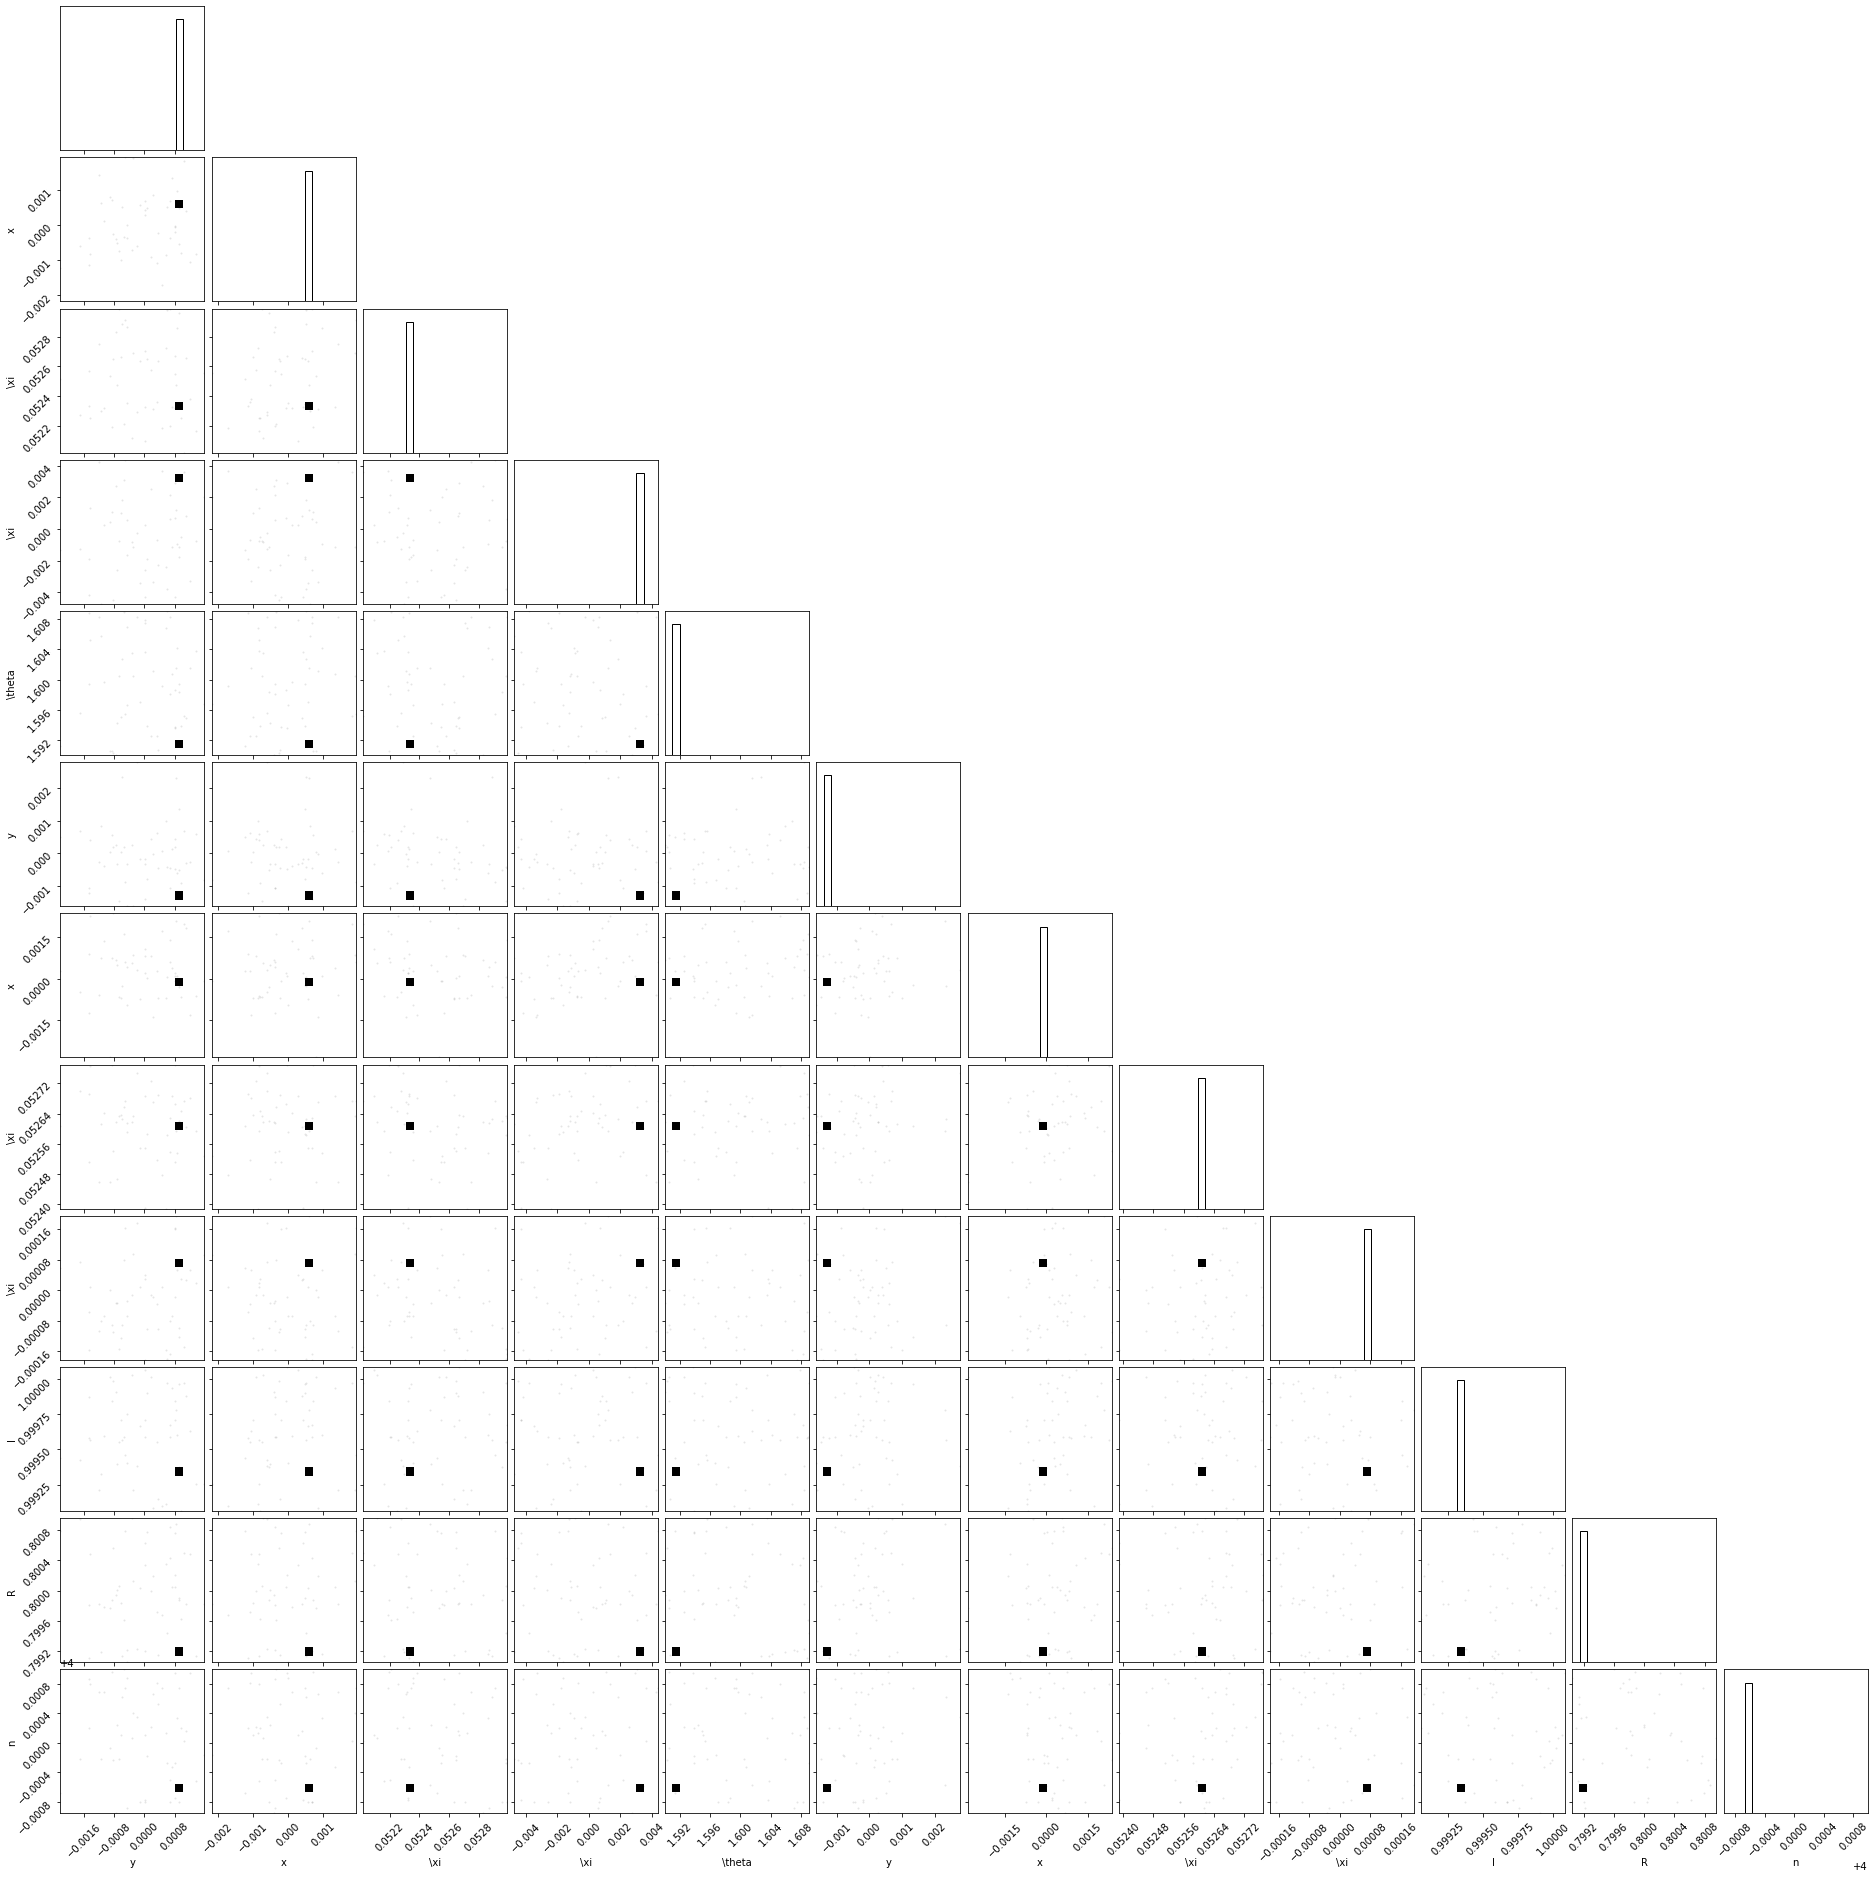

In [17]:
import corner

corner.corner(
    xs=samples.parameters,
    weights=samples.weights,
    labels=samples.model.parameter_labels,
)


__Aggregator__

Once a phase has completed running, we have a set of results on our hard disk we manually inspect and analyse. 
Alternatively, we return the results from the phase.run() method and manipulate them in a Python script, as we did
in this script.

However, imagine your dataset is large and consists of many images of strong lenses. You analyse each image 
individually using the same phase, producing a large set of results on your hard disk corresponding to the full sample.
That will be a lot of paths and directories to navigate! At some point, there`ll be too many results for it to be
a sensible use of your time to analyse the results by sifting through the outputs on your hard disk.

PyAutoFit`s aggregator tool allows us to load results in a Python script or, more importantly, a Jupyter notebook. This
bypasses the need for us to run a phase and can load the results of any number of lenses at once, allowing us to 
manipulate the results of extremely large lens samples!

If the `Aggregator`. sounds useful to you, then checkout the tutorials in the path:

 `autolens_workspace/advanced/aggregator`